### TYK2 DMS/FlowDMS Integration with Barcode Subsampling

Combining protein stability data from FlowDMS and signaling activity data from standard DMS has proven powerful for identifying mutational signatures of interest (e.g. candidate allosteric sites). Consequently, we would like to evaluate the effect of reducing barcode sampling depth in one or both assays.

Resampled mapped counts files were generated with:

```
echo 3 5 8 10 15 | \
    tr " " "\n" | \
    parallel python src/resample-mapped-counts.py \
        -i pipeline/TYK2/OCNT-DMSLIB-1-assay-run7/tyk2.mapped-counts.tsv \
        -o pipeline/resample/tyk2-n{}.mapped-counts.tsv \
        -n {}

echo 3 5 8 10 15 | \
    tr " " "\n" | \
    parallel python src/resample-mapped-counts.py \
        -i pipeline/TYK2-FLOW/OCNT-VAMPLIB-1-assay-run2B/tyk2-vamp-combined.mapped-counts.tsv \
        -o pipeline/resample/tyk2-flow-n{}.mapped-counts.tsv \
        -n {}
```

Each generated set of counts was processed with the same pipeline as before, including the conversion of per-bin flowDMS summary statistics into midpoints. The sections below examine the effects of subsampling on each assay separately, and then on the results from combining them.

In [2]:
library(fs)
library(scales)
library(scico)
library(ggpubr)
library(tidyverse)

source("../src/dms-analysis-utils.R")

#### Subsampling FlowDMS

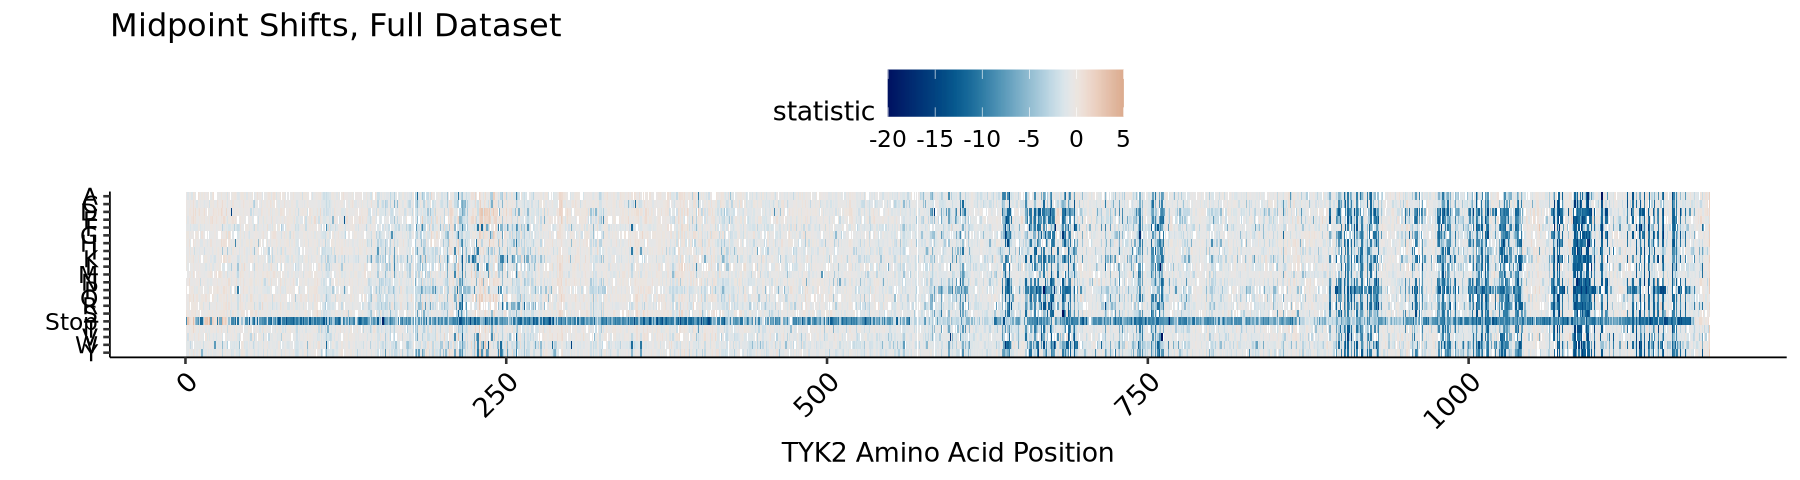

In [62]:
original_midpoints <- read_tsv("../sumstats/TYK2-VAMP/run2B/tyk2-vamp-combined-flow-cleaned.midpoints.tsv",
                               show_col_types = FALSE) %>%
    mutate(aa = if_else(aa %in% c("X", "*"), "Stop", aa))

options(repr.plot.width = 15, repr.plot.height = 4)
original_midpoints %>% 
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =statistic)) +
            scale_fill_scico_mid( limits = c(-20,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            ggtitle("Midpoint Shifts, Full Dataset")

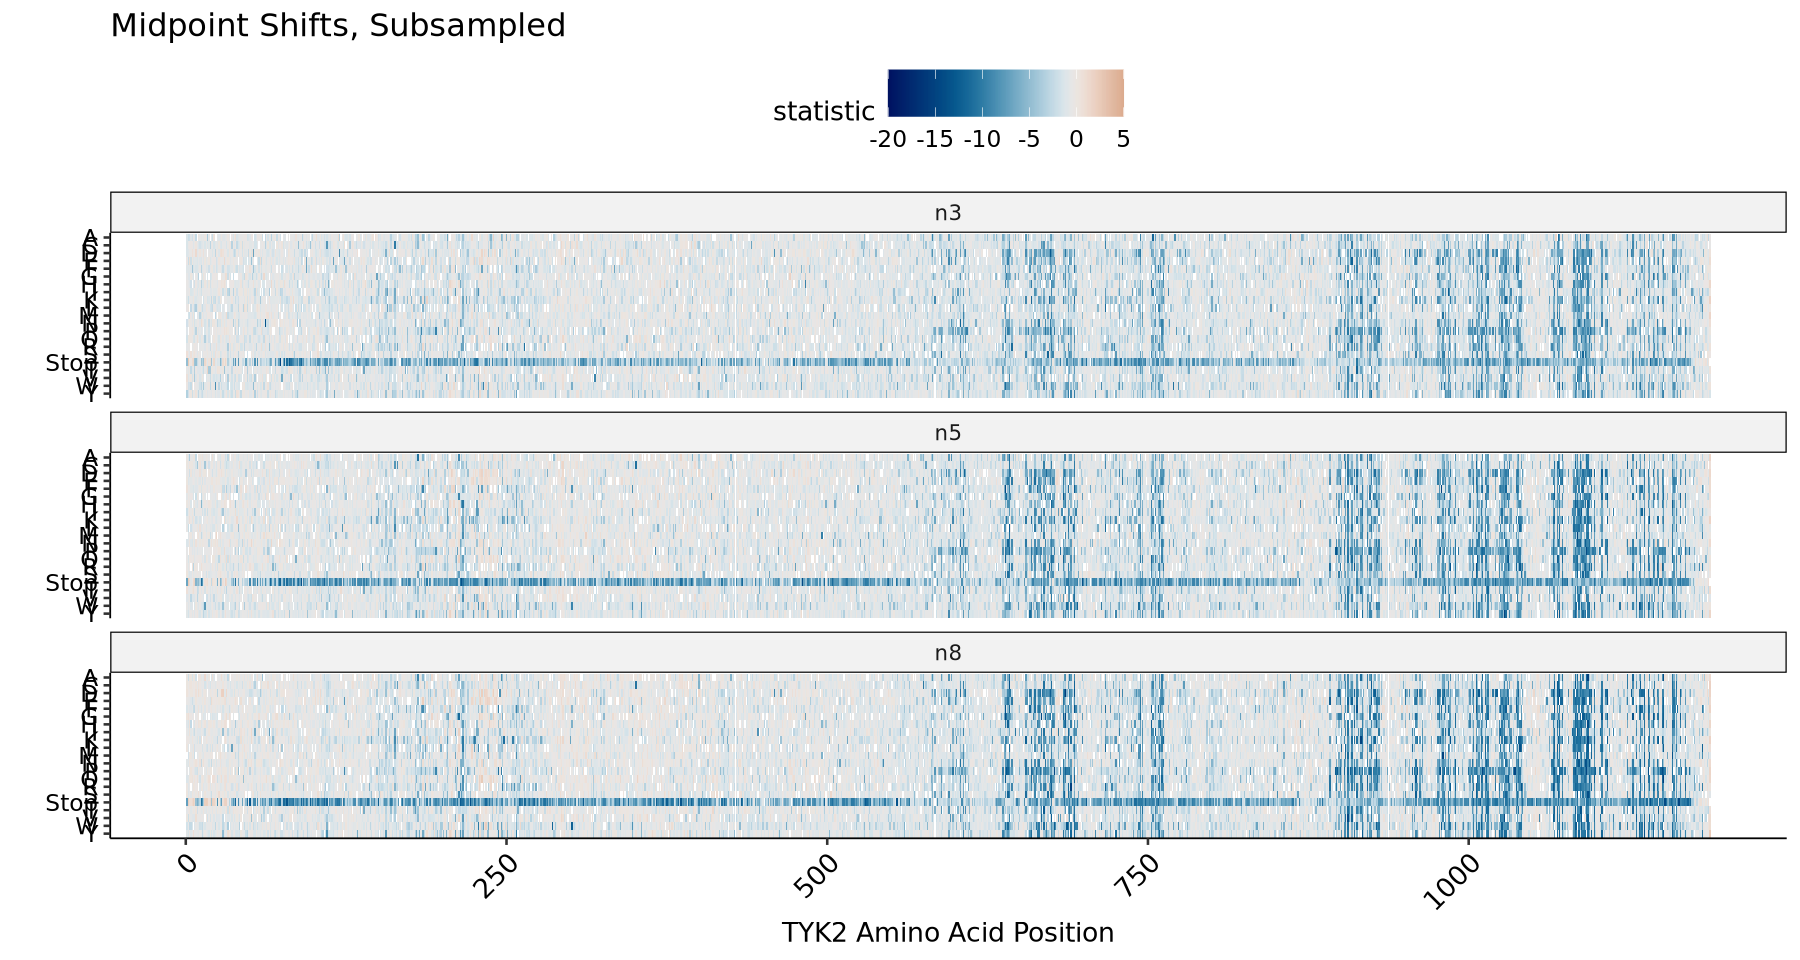

In [63]:
flow_files <- dir_ls("../sumstats/TYK2-VAMP/run2B/resample", glob = "*.midpoints.tsv")
flow_sumstats <- read_tsv(flow_files, id = "n", show_col_types = FALSE) %>%
    mutate(n = gsub("../sumstats/TYK2-VAMP/run2B/resample/tyk2-flow-|-flow-cleaned.midpoints.tsv", "", n),
           n = factor(n, levels = c("n3", "n5", "n8", "n10", "n15")),
           aa = if_else(aa %in% c("X", "*"), "Stop", aa))

options(repr.plot.width = 15, repr.plot.height = 8)
flow_sumstats %>% 
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =statistic)) +
            scale_fill_scico_mid( limits = c(-20,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~n, ncol = 1) +
            ggtitle("Midpoint Shifts, Subsampled")

#### Subsampling Signaling DMS

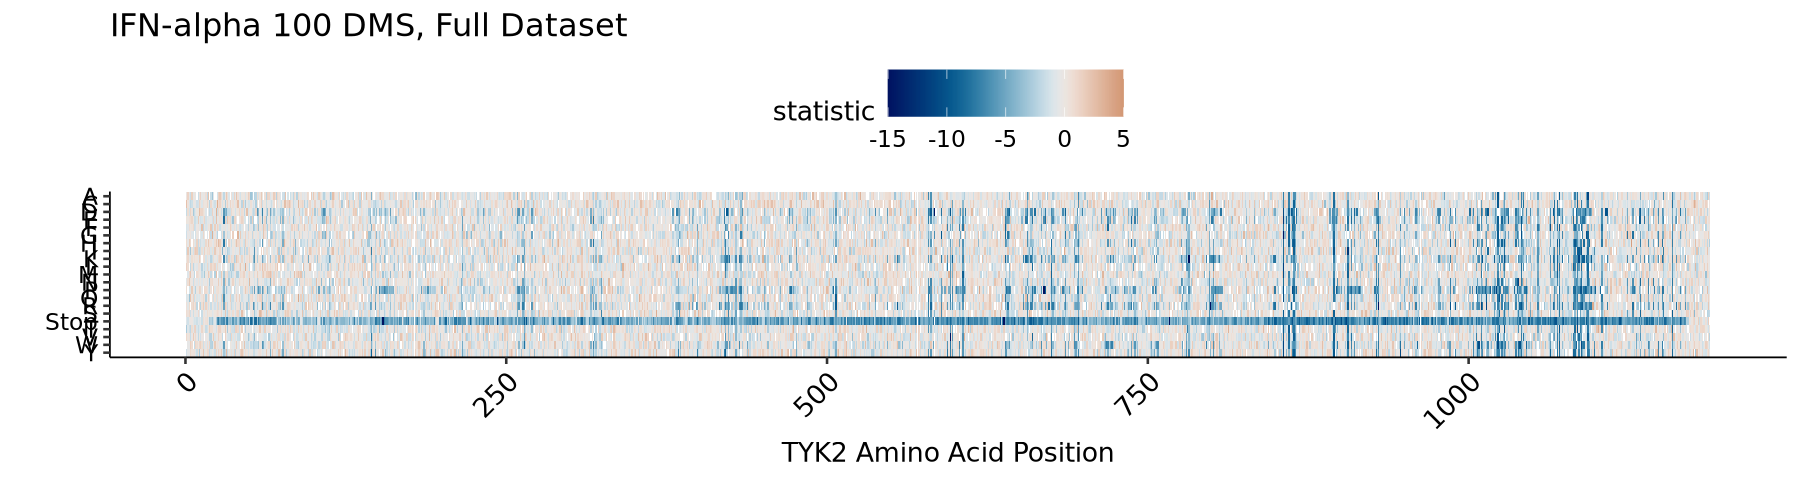

In [64]:
original_dms <- read_tsv("../sumstats/BMS/BMS-FINAL/TYK2-run7-combined-cleaned.sumstats.tsv",
                         show_col_types = FALSE) %>%
    mutate(aa = if_else(aa %in% c("X", "*"), "Stop", aa))

options(repr.plot.width = 15, repr.plot.height = 4)
original_dms %>% 
    filter(condition == "IFNalpha100_0") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =statistic)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            ggtitle("IFN-alpha 100 DMS, Full Dataset")

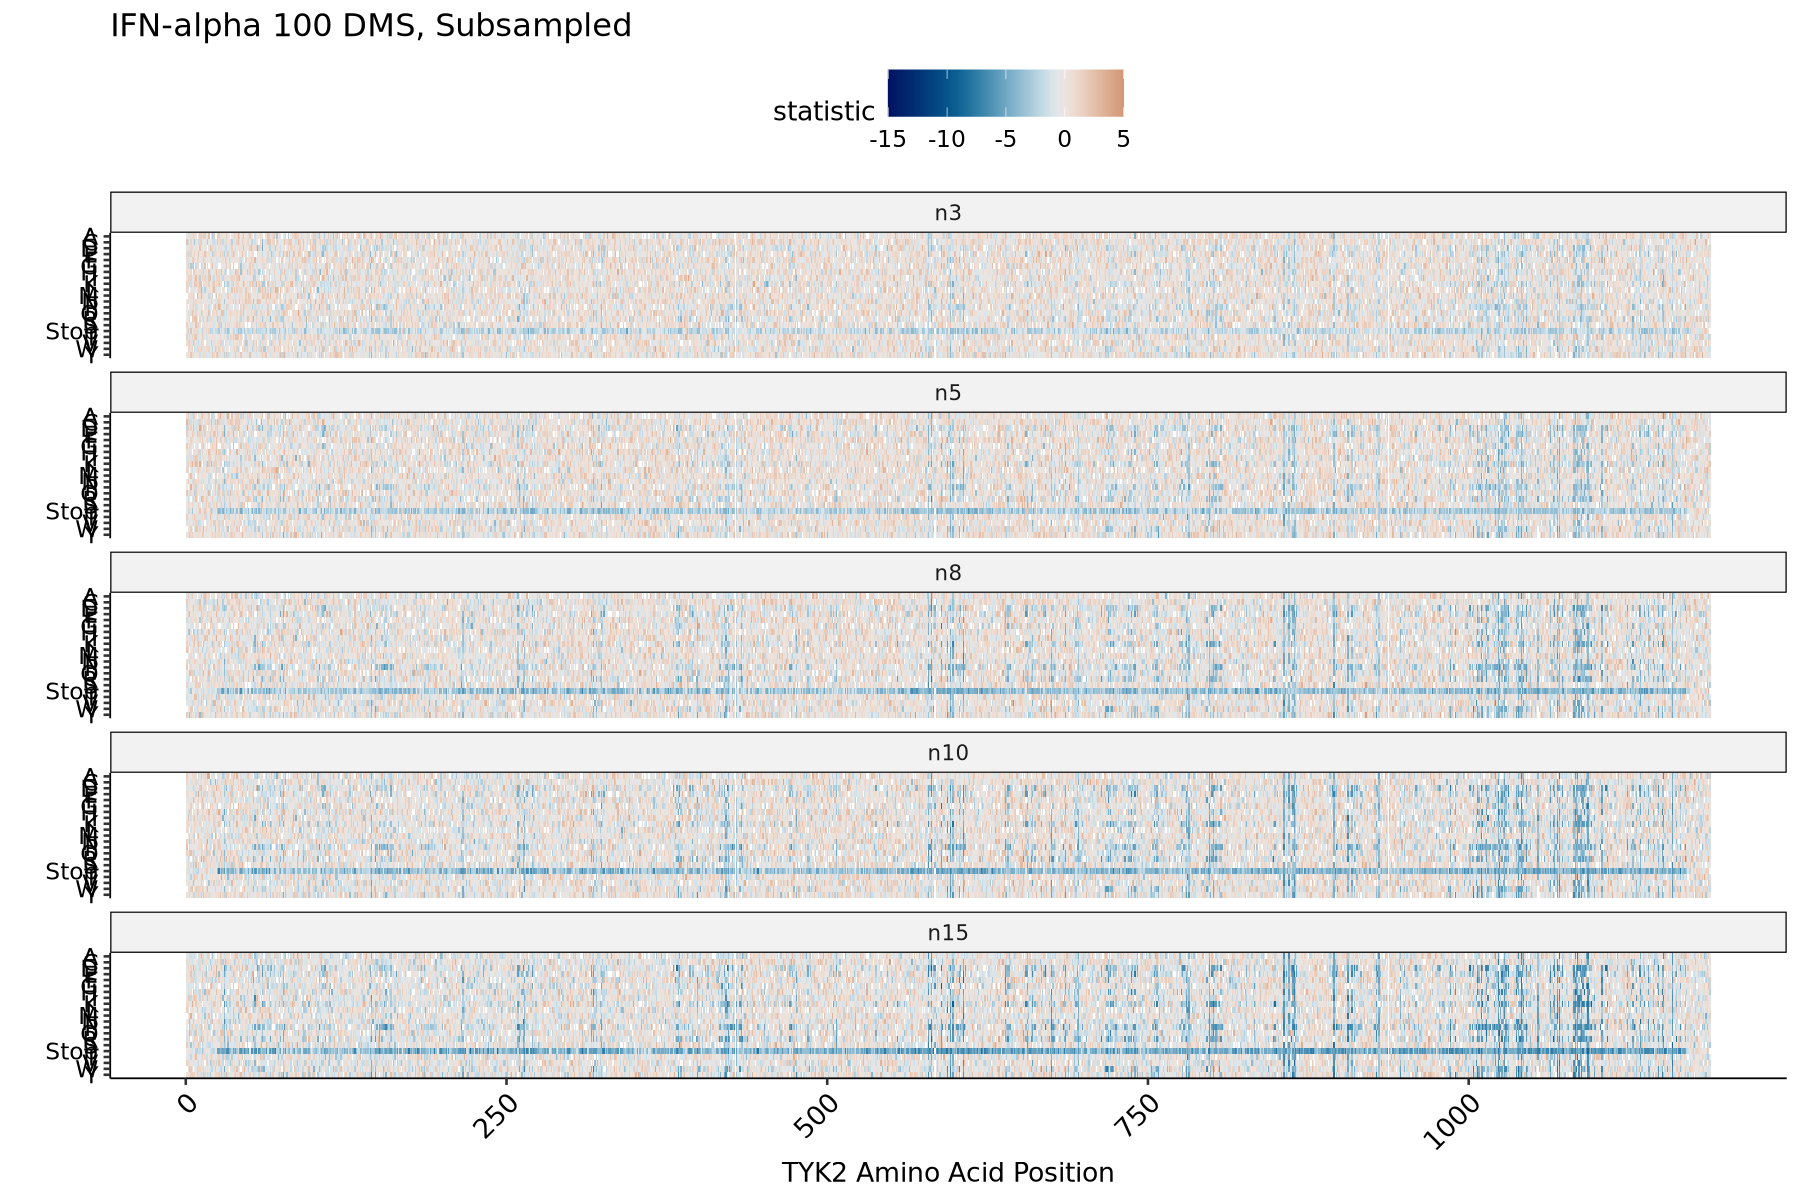

In [65]:
dms_files <- dir_ls("../sumstats/TYK2/run7/resample", glob = "*-cleaned.sumstats.tsv")
dms_sumstats <- read_tsv(dms_files, id = "n", show_col_types = FALSE) %>%
    mutate(n = gsub("../sumstats/TYK2/run7/resample/tyk2-|-combined-cleaned.sumstats.tsv", "", n),
           n = factor(n, levels = c("n3", "n5", "n8", "n10", "n15")),
           aa = if_else(aa %in% c("X", "*"), "Stop", aa))

options(repr.plot.width = 15, repr.plot.height = 10)
dms_sumstats %>% 
    filter(condition == "IFNalpha100_0") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =statistic)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~n, ncol = 1) +
            ggtitle("IFN-alpha 100 DMS, Subsampled")

#### Matched Subsampling 

In [66]:
flow_join <- flow_sumstats %>%
    select(n, pos, aa, midpoint_shift, midpoint_shift_se, statistic) %>%
    rename("midpoint_statistic" = "statistic")

dms_join <- dms_sumstats %>%
    filter(condition == "IFNalpha100_0") %>%
    select(n, pos, aa, log2FoldChange, log2StdError, statistic) %>%
    rename("dms_statistic" = "statistic")

joined <- inner_join(dms_join, flow_join, by = join_by(n, pos, aa))

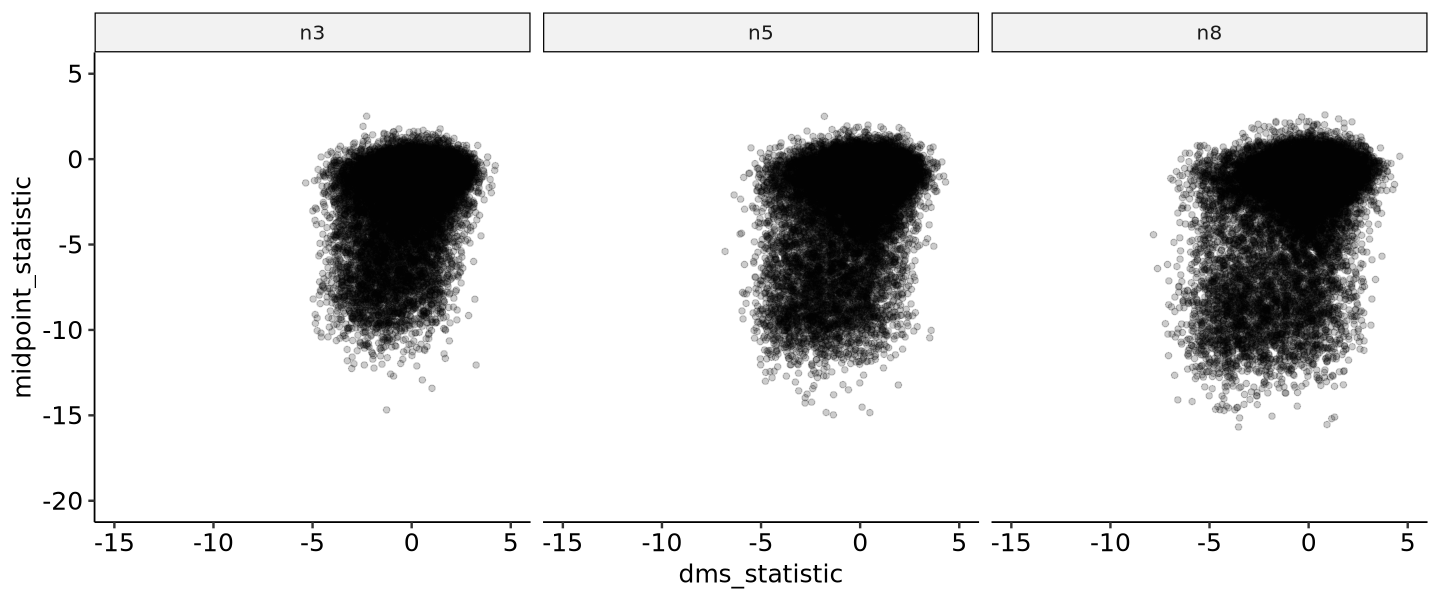

In [67]:
options(repr.plot.width = 12, repr.plot.height = 5)
joined %>%
    ggplot() +
        geom_point(aes(x = dms_statistic,
                       y = midpoint_statistic), alpha = 0.2) +
        theme_pubr(base_size = 15) +
        facet_wrap(~n) +
        coord_cartesian(xlim = c(-15, 5),
                        ylim = c(-20, 5))